This notebook is a stripped version of the "BLG berry curvature dipole" notebook with much less of the theory background, which has been moved to a working draft of my thesis.

In [132]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import simps # numerical integration

In [2]:
%matplotlib notebook

# Setup
## Define fixed parameters/constants/functions

In [347]:
# Physical parameters
hbar = 6.5821e-16 # eV * s
q = 1.602176634e-19 # Coulomb, electron charge (also eV to J conversion)
m_e = 9.1093837015e-31 / q # kg divide by electron charge to take care of a J-> eV conversion
muB = q * hbar / (2 * m_e) # Bohr magneton J/T = A*m^2 (hbar/m takes care of J->eV conversion)
kB = 8.617333262145e-5 # Boltzmann constant eV/K
eps0 = 8.8541878128e-12 # vacuum permittivity C/V*m

# Graphene
a = 0.246e-9 # meters, lattice constant for graphene
d = 0.34e-9 # meters, interlayer distance for BLG

A_BZ = 2 * (np.pi/a)**2 * np.sqrt(3) # area of BZ, m^-2
    

# Hopping parameters (eV)
gamma0 = 3.161 
gamma1 = 0.381
gamma3 = 0.38
gamma4 = 0.14
dab = 0.022  # dimer asymmetry

# Fermi velocities m * eV / (eV * s) = m/s
v0 = np.sqrt(3) * a * gamma0 / (2 * hbar) 
v3 = np.sqrt(3) * a * gamma3 / (2 * hbar)
v4 = np.sqrt(3) * a * gamma4 / (2 * hbar)

# Estimated Gruneisen parameters
eta0 = -2
eta3 = -1
eta4 = -1

# Model parameters
nu = 0.165  # Poisson ratio for graphene (in general this should be that of the substrate)

# Fermi-Dirac distribution - treating electrons and holes differently
def feq_func(E, EF, T=0, thresh=0.01):
    # Energy (n bands X number of kx points X number of ky points array) in eV
    # EF chemical potential in eV
    # Temperature in K     
        
    if T < 1e-10:
        T = 1e-10 # small but finite to avoid dividing by zero
    f = 1 / (1 + np.exp((E-EF) / (kB * T)))
    f[E<0] = 1 - f[E<0] # for holes
    
    for n in range(f.shape[0]): # loop over bands
        below_threshold = True # threshold to check if FD is small enough at boundaries of k-space
        for i in [0, -1]:
            if (f[n, i, :] > thresh).any():
                below_threshold = False
            elif (f[n, :, i] > thresh).any():
                below_threshold = False
        if not below_threshold:
            print('F-D dist in band %i not smaller than %f at boundaries!' %(n, thresh))
            
    return f

## Calculating area of BZ:

In [346]:
from IPython.display import Image
from IPython.core.display import HTML 

url = 'https://d3i71xaburhd42.cloudfront.net/7b770235935d991201fd9a18e84b56f0052c60df/24-Figure1-1.png'
Image(url= url, width=500)

We need the area of a hexagon with edge-to-edge distance $\frac{2\pi}{a}$. From Wikipedia, this is $2\left(\frac{\pi}{a}\right)^2\sqrt{3}$.

## Define Hamiltonian and eigenstates

$$
H = \left(
\begin{array}{cccc}
    -\frac12\Delta   &   v_3\pi + w_3    &   -v_4\pi^\dagger - w_4^*  &   v_0\pi^\dagger   \\
    v_3\pi^\dagger + w_3^*      &   \frac12\Delta     &   v_0\pi   &   -v_4\pi - w_4   \\
    -v_4\pi - w_4       &   v_0\pi^\dagger       &   \frac12\Delta + \Delta_{\text{AB}}   &   \gamma_1   \\
    v_0\pi            &   -v_4\pi^\dagger - w_4^*  &   \gamma_1   &   -\frac12\Delta + \Delta_{\text{AB}}   \\
\end{array}
\right)
$$
where $\pi= \xi \hbar k_x + i \hbar k_y$.

In [4]:
def Hfunc(kx, ky, Delta=0.02, delta=0.02, xi=1, theta=0):
    deltap = -nu * delta  # strain along transverse direction

    w3 = 3 / 4 * np.exp(-1j*2*xi*theta)*(delta-deltap)*(eta3 - eta0)*gamma3
    w4 = 3 / 4 * np.exp(-1j*2*xi*theta)*(delta-deltap)*(eta4 - eta0)*gamma4

    w3s = w3.conjugate()
    w4s = w4.conjugate()
    
    px, py = hbar * kx, hbar * ky
    pi = xi * px + 1j * py
    pidag = xi * px - 1j * py
    
    return np.array([
        [-1/2 * Delta,      v3 * pi + w3,       -v4 * pidag - w4s,  v0*pidag],
        [v3 * pidag + w3s,  1/2 * Delta,        v0 * pi,            -v4 * pi - w4],
        [-v4 * pi - w4,     v0 * pidag,         1/2 * Delta + dab,  gamma1 * pi/pi],
        [v0 * pi,           -v4 * pidag - w4s,  gamma1 * pi/pi,     -1/2 * Delta + dab]
    ])

## Diagonalize the Hamiltonian numerically

In [8]:
def calculate(kx, ky, params):
    E = np.zeros((4, len(ky), len(kx)))
    Psi = np.zeros((4, 4, len(ky), len(kx)), dtype='complex')
    H = np.zeros_like(Psi)
    
    for i, x in enumerate(kx):
        for j, y in enumerate(ky):
            h = Hfunc(x, y, **params)

            eigs, vecs = np.linalg.eigh(h) # Use eigh for Hermitian
             # guaranteed sorted real eigenvalues
            vecs = vecs.T # eigenvectors are in the columns -> transpose to put in rows

            # Fix sign ambiguity
            for k in range(len(vecs)):
                if vecs[k][0].real < 0: # check sign of first component
                    vecs[k] *= -1 # guarantee first component is positive

            E[:, j, i] = eigs # Energy for the two bands
            Psi[:, :, j, i] = vecs
            H[:, :, j, i] = h
    return E, Psi, H

In [9]:
params = dict(
    Delta=0.02, # eV
    delta=0.02,
    xi=1,
    theta=0
)

# Looking at figures in Battilomo et al.
# kx and ky from roughly -5 to 5 (in units of \epsilon_L = 0.035 nm^-1)
kx = np.linspace(-5, 5, 300) * 0.035 * 1e9 # nm^-1 -> m^-1
ky = kx.copy()

Kx, Ky = np.meshgrid(kx, ky)

E, Psi, H = calculate(kx, ky, params) # E sorted high to low

In [10]:
j, i = 20, 40
b = 1
e = E[b, j, i]
h = np.matrix(H[:, :, j, i])
psi = np.matrix(Psi[b, :, j, i]).T

np.allclose(h @ psi / e,psi)

True

Energy bands look good:

<IPython.core.display.Javascript object>


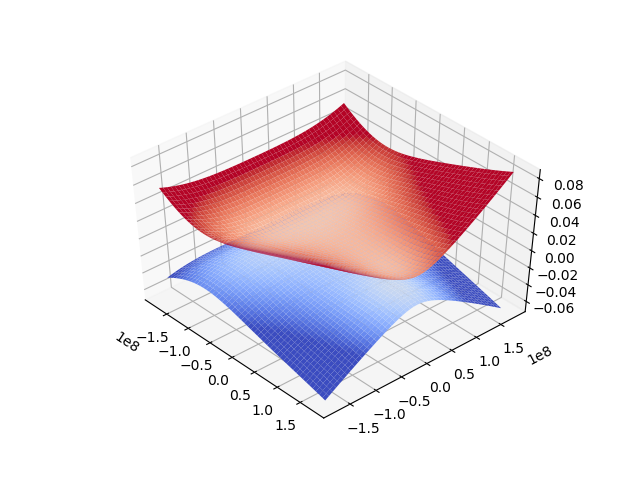

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for e, psi in zip(E[1:3], Psi[1:3]): #[1:3] takes the two low-energy bands
    ax.plot_surface(Kx, Ky, e, cmap='coolwarm', vmin=-0.040, vmax=0.040)

<IPython.core.display.Javascript object>


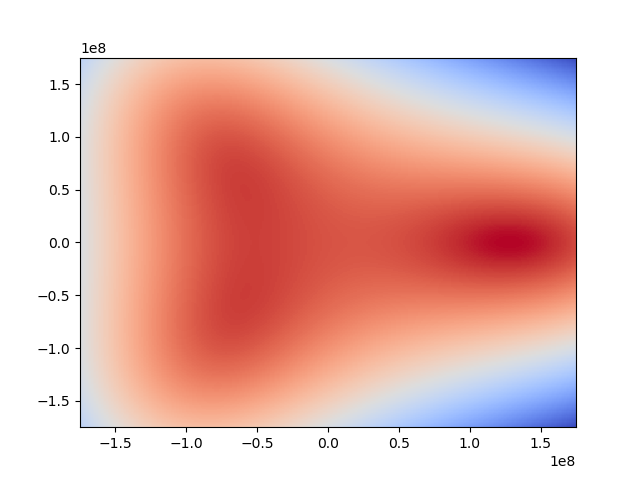

In [12]:
fig, ax = plt.subplots()
ax.pcolormesh(Kx, Ky, E[1], cmap='coolwarm')

### Fixed eigenvector sign ambiguity by enforcing real part of first component is positive
This many not be necessary, since berry curvature and magnetic moment below will always involve products of eigenstates and their conjugates, which should make the negative signs cancel

<IPython.core.display.Javascript object>


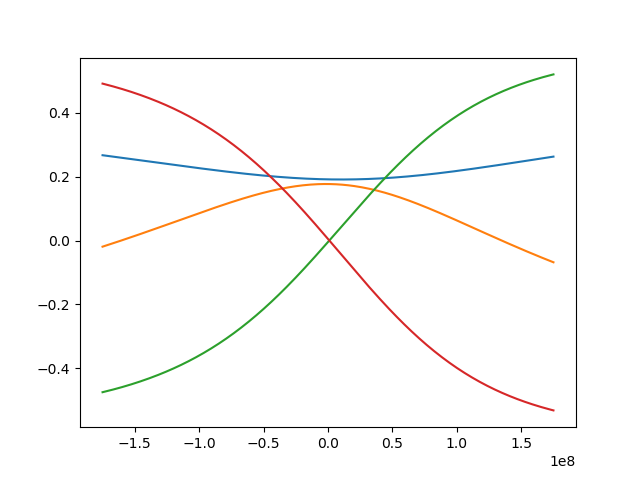

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)

for i in range(4):
    ax.plot(kx, (Psi[0,i,20,:].real))

## Berry curvature and orbital magnetic moment

$$
\newcommand{\braket}[3]{\langle#1|#2|#3\rangle}
\Omega_n^z = -2\, \text{Im} \sum_{m\neq n}\frac{\braket{n}{\partial_{k_x}H}{m}\braket{m}{\partial_{k_y}H}{n}}{(\epsilon_n-\epsilon_m)^2}
\hspace{1cm}
\mu_n^z = -\frac{e}{\hbar} \, \text{Im} \sum_{m\neq n}\frac{\braket{n}{\partial_{k_x}H}{m}\braket{m}{\partial_{k_y}H}{n}}{\epsilon_n-\epsilon_m}
$$
The sum for band $n$ runs over all other bands $m$.

$$
H = \left(
\begin{array}{cccc}
    -\frac12\Delta   &   v_3\pi + w_3    &   -v_4\pi^\dagger - w_4^*  &   v_0\pi^\dagger   \\
    v_3\pi^\dagger + w_3^*      &   \frac12\Delta     &   v_0\pi   &   -v_4\pi - w_4   \\
    -v_4\pi - w_4       &   v_0\pi^\dagger       &   \frac12\Delta + \Delta_{\text{AB}}   &   \gamma_1   \\
    v_0\pi            &   -v_4\pi^\dagger - w_4^*  &   \gamma_1   &   -\frac12\Delta + \Delta_{\text{AB}}   \\
\end{array}
\right)
$$
where $\pi= \xi \hbar k_x + i \hbar k_y$.

We can take the derivatives by hand and calculate the matrices directly. Noting $\partial_{k_x}\pi= \partial_{k_x}\pi^\dagger =\xi \hbar$ and $\partial_{k_y} \pi^{(\dagger)} = (-)i\hbar$,

$$
\partial_{k_x} H = \xi\hbar\left(
\begin{array}{cccc}
    0   &   v_3    &   -v_4  &   v_0   \\
    v_3      &   0     &   v_0   &   -v_4   \\
    -v_4       &   v_0       &   0   &   0   \\
    v_0            &   -v_4 &   0   &   0   \\
\end{array}
\right)
\hspace{1cm}
\partial_{k_x} H = i\hbar\left(
\begin{array}{cccc}
    0   &   v_3    &   v_4  &   -v_0   \\
    -v_3      &   0     &   v_0   &   -v_4   \\
    -v_4       &   -v_0       &   0   &   0   \\
    v_0            &   v_4 &   0   &   0   \\
\end{array}
\right)
$$

These are both independent of $k_x$ and $k_y$.

In [16]:
def H_dkx(xi=1):  # units are eV * s * m / s = eV * m
    return xi * hbar * np.array([
        [0, v3, -v4, v0],
        [v3, 0, v0, -v4],
        [-v4, v0, 0, 0],
        [v0, -v4, 0, 0]
    ])

def H_dky():
    return 1j * hbar * np.array([
        [0, v3, v4, -v0],
        [-v3, 0, v0, -v4],
        [-v4, -v0, 0, 0],
        [v0, v4, 0, 0]
    ])

In [17]:
hdky = H_dky()

In [19]:
def berry_mu(E, Psi, Delta=0.02, delta=0.02, xi=1, theta=0):
    # e: array of 4 energy eigenvalues
    # psi: array of 4 energy eigenvectors of length 4
    # returns: Berry curvature (units m^2)
    #          magnetic moment (units Bohr magneton)
    hdkx, hdky = H_dkx(xi), H_dky()
    
    # Convert to matrices to make multiplication easier
    hdkx = np.matrix(hdkx)
    hdky = np.matrix(hdky)
    
    Omega = np.zeros(len(hdkx)) # length 4 array
    Mu = np.zeros(len(hdkx))
    
    for n, (e_n, psi_n) in enumerate(zip(E, Psi)):
        psi_n = np.matrix(psi_n).T # transpose to a column vector
        for e_m, psi_m in zip(E, Psi):
            if e_n == e_m: # sum runs over n != m
                continue
                
            psi_m = np.matrix(psi_m).T # transpose to a column vector
                
            # Using .H for Hermitian conjugate
            # .item() removes the number from the 1x1 resulting matrix
            num = ((psi_n.H @ hdkx @ psi_m) * (psi_m.H @ hdky @ psi_n)).item()
            denom = e_n - e_m

            Omega[n] += np.imag(num / (denom) ** 2)
            Mu[n] += np.imag(num / denom)
            
    Omega = -2 * Omega
    Mu = -q / hbar * Mu / muB# -> Bohr magnetons
                # [C / (eV * s)] * [(eV * m)^2 / eV] * [1 / A*m^2]
                # result should be dimensionless
    
    return Omega, Mu

## Redefine `calculate` function to include berry curvature and magnetic moment

In [20]:
def calculate(kx, ky, params):
    E = np.zeros((4, len(ky), len(kx)))
    Psi = np.zeros((4, 4, len(ky), len(kx)), dtype='complex')
    Omega = np.zeros((4, len(ky), len(kx)))
    Mu = np.zeros((4, len(ky), len(kx)))
    
    for i, x in enumerate(kx):
        for j, y in enumerate(ky):
            h = Hfunc(x, y, **params)

            eigs, vecs = np.linalg.eigh(h) # Use eigh for Hermitian
             # guaranteed sorted real eigenvalues
            vecs = vecs.T # eigenvectors are in the columns -> transpose to put in rows

            # Fix sign ambiguity
            for k in range(len(vecs)):
                if vecs[k][0].real < 0: # check sign of first component
                    vecs[k] *= -1 # guarantee first component is positive

            E[:, j, i] = eigs # Energy for the two bands
            Psi[:, :, j, i] = vecs # eigenstates
            
            Omega[:, j, i], Mu[:, j, i] = berry_mu(eigs, vecs)
            
    return E, Psi, Omega, Mu

In [21]:
import time

In [246]:
params = dict(
    Delta=0.01, # eV
    delta=0.0,
    xi=1,
    theta=0
)

# Looking at figures in Battilomo et al.
# kx and ky from roughly -5 to 5 (in units of \epsilon_L = 0.035 nm^-1)
# let's double this to make the integration happy
kx = np.linspace(-10, 10, 200) * 0.035 * 1e9 # nm^-1 -> m^-1
ky = kx.copy()

Kx, Ky = np.meshgrid(kx, ky)

t0 = time.time()
E, Psi, Omega, Mu = calculate(kx, ky, params) # E sorted high to low
print(time.time()-t0)

29.553966283798218


### Testing computation time

In [ ]:
times = []
for N in [10, 20, 30, 40, 50]:
    kx = np.linspace(-5, 5, N) * 0.035 * 1e9 # nm^-1 -> m^-1
    ky = kx.copy()

    Kx, Ky = np.meshgrid(kx, ky)

    t0 = time.time()
    E, Psi, Omega, Mu = calculate(kx, ky, params) # E sorted high to low
    times.append(time.time()-t0)

In [424]:
Ns = np.array([10, 20, 30, 40, 50, 300])
# times.append(99.93686747550964)

In [304]:
times

[0.13991975784301758,
 0.44774317741394043,
 0.96844482421875,
 1.7440004348754883,
 2.6964540481567383,
 99.93686747550964]

<IPython.core.display.Javascript object>


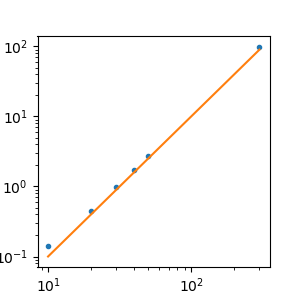

In [305]:
fig, ax = plt.subplots(figsize=(3,3))
ax.loglog(Ns, times, '.')
ax.loglog(Ns, .001*Ns**2)

$\mathcal{O}(N^2)$ computation time (one calculation for each kx, ky pair). ~100 seconds for $N=300$. Not too bad, let's avoid cumbersome numerical optimization for now.

## Visualize Berry curvature and magnetic moment

<IPython.core.display.Javascript object>


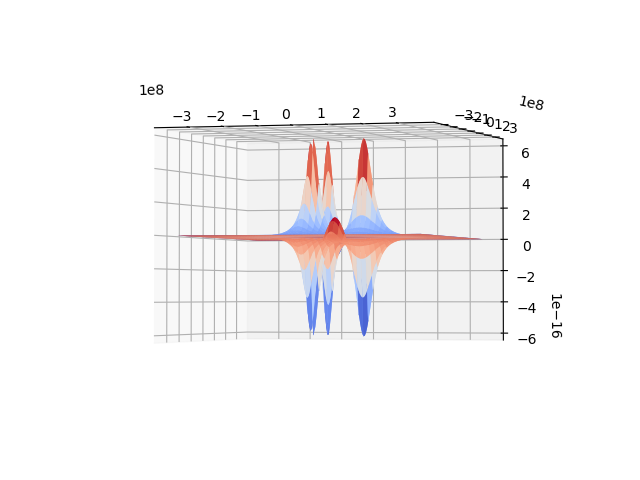

In [247]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

b = slice(0,4)

for e, psi, omega, mu in zip(E[b], Psi[b], Omega[b], Mu[b]): #[1:3] takes the two low-energy bands
    ax.plot_surface(Kx, Ky, omega, cmap='coolwarm')#, vmin=-0.040, vmax=0.040)

<IPython.core.display.Javascript object>


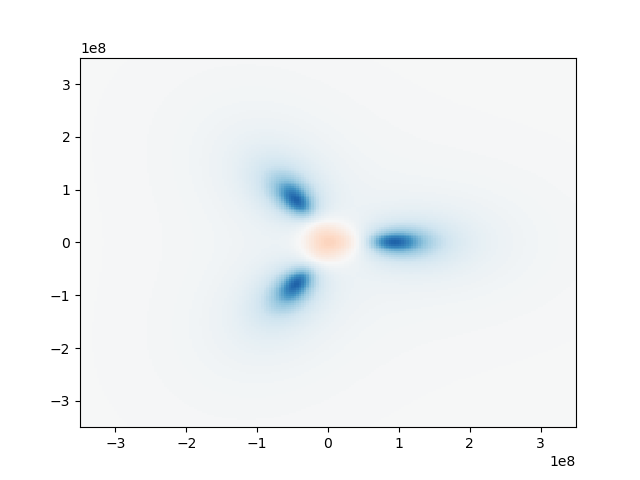

In [248]:
vmin = 100
fig, ax = plt.subplots()
ax.pcolormesh(Kx, Ky, Mu[1], vmin=-vmin, vmax=vmin, cmap='RdBu')

## All bands for K and K'

In [249]:
kx = np.linspace(-10, 10, 200) * 0.035 * 1e9 # nm^-1 -> m^-1
ky = kx.copy()

Kx, Ky = np.meshgrid(kx, ky)

# K
params = dict(
    Delta=0.01, # eV
    delta=0,
    xi = 1,
    theta=0
)
E, Psi, Omega, Mu = calculate(kx, ky, params) # E sorted high to low

params = dict(
    Delta=0.01, # eV
    delta=0,
    xi = -1,
    theta=0
)
E1, Psi1, Omega1, Mu1 = calculate(kx, ky, params) # E sorted high to low



<IPython.core.display.Javascript object>


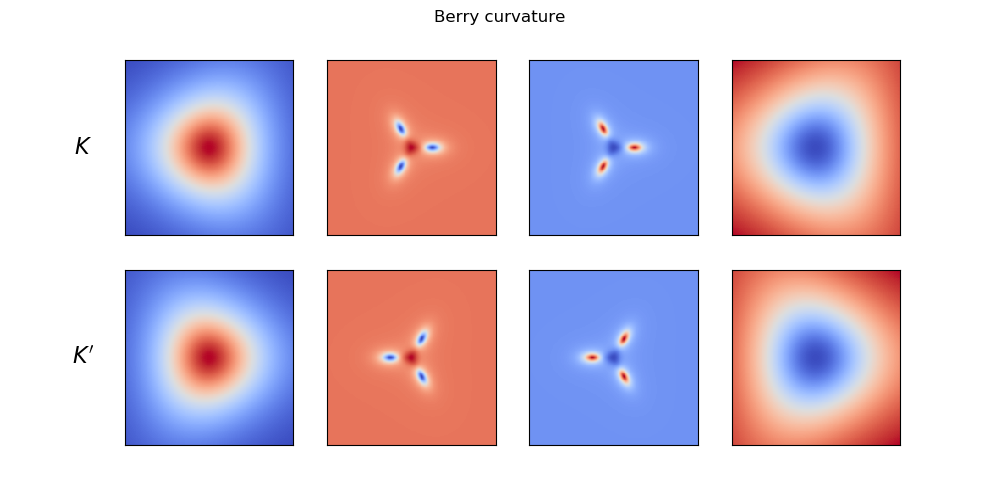

In [250]:
fig, ax = plt.subplots(2,4, figsize=(10,5))

for j in range(4):  # bands
    ax[0,j].pcolormesh(Kx, Ky, Omega[j], cmap='coolwarm')
    ax[1,j].pcolormesh(Kx, Ky, Omega1[j], cmap='coolwarm')

ax[0,0].set_ylabel('$K$', rotation=0, labelpad=30, fontsize=16, va='center')
ax[1,0].set_ylabel('$K\'$', rotation=0, labelpad=30, fontsize=16, va='center')
    
fig.suptitle('Berry curvature')

for a in ax.flatten():
    a.set_xticks([])
    a.set_yticks([])

<IPython.core.display.Javascript object>


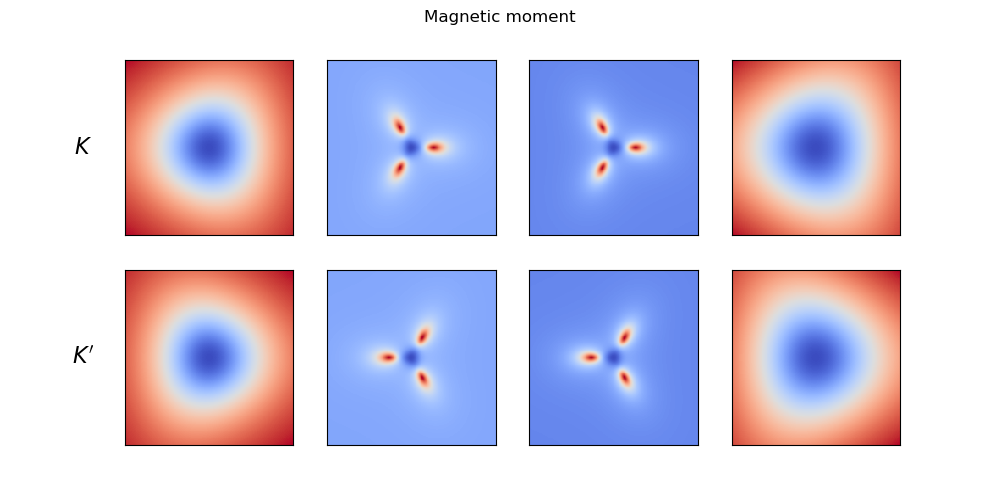

In [251]:
fig, ax = plt.subplots(2,4, figsize=(10,5))

for j in range(4):  # bands
    ax[0,j].pcolormesh(Kx, Ky, Mu[j], cmap='coolwarm')
    ax[1,j].pcolormesh(Kx, Ky, Mu1[j], cmap='coolwarm')

ax[0,0].set_ylabel('$K$', rotation=0, labelpad=30, fontsize=16, va='center')
ax[1,0].set_ylabel('$K\'$', rotation=0, labelpad=30, fontsize=16, va='center')
    
fig.suptitle('Magnetic moment')

for a in ax.flatten():
    a.set_xticks([])
    a.set_yticks([])

## Effective mass

the effective mass tensor with components $\left(\frac{1}{m^{*n}}\right)_{ij} = \frac{1}{\hbar^2}\frac{\partial^2 E_n}{\partial k_i \partial k_j}$

In [252]:
def meff_func(kx, ky, E):
    # returns the inverse of the reciprocal effective mass tensor, divided by the electron mass
    # returns a 4 x 2 x 2 x len(kx) x len(ky) array
    # 1st dimension: bands
    # 2nd/3rd dimensions: 2x2 effective mass tensor
    # 4th/5th dimensions: value of the tensor for each kx, ky point
    E_dky, E_dkx = np.gradient(E, ky, kx, axis=(1,2), edge_order=2) # axis1 = y, axis2 = x
    
    E_dkx_dky, E_dkx_dkx = np.gradient(E_dkx, ky, kx, axis=(1,2), edge_order=2)
    E_dky_dky, E_dky_dkx = np.gradient(E_dky, ky, kx, axis=(1,2), edge_order=2)
    
    if E.shape[0] != 4:
        raise Exception('Something is wrong... size of E is not 4 x ...')
    
    oneoverm = np.zeros((E.shape[0], len(kx), len(ky), 2, 2))
    
    oneoverm[:, :, :, 0, 0] = E_dkx_dkx / hbar**2
    oneoverm[:, :, :, 0, 1] = E_dky_dkx / hbar**2
    oneoverm[:, :, :, 1, 0] = E_dkx_dky / hbar**2
    oneoverm[:, :, :, 1, 1] = E_dky_dky / hbar**2
    
    # np.linalg.inv will operate over last two axes
    return np.linalg.inv(oneoverm) / m_e # m_e divided by q already to take care of eV -> J conversion

In [253]:
meff = meff_func(kx, ky, E)

<IPython.core.display.Javascript object>


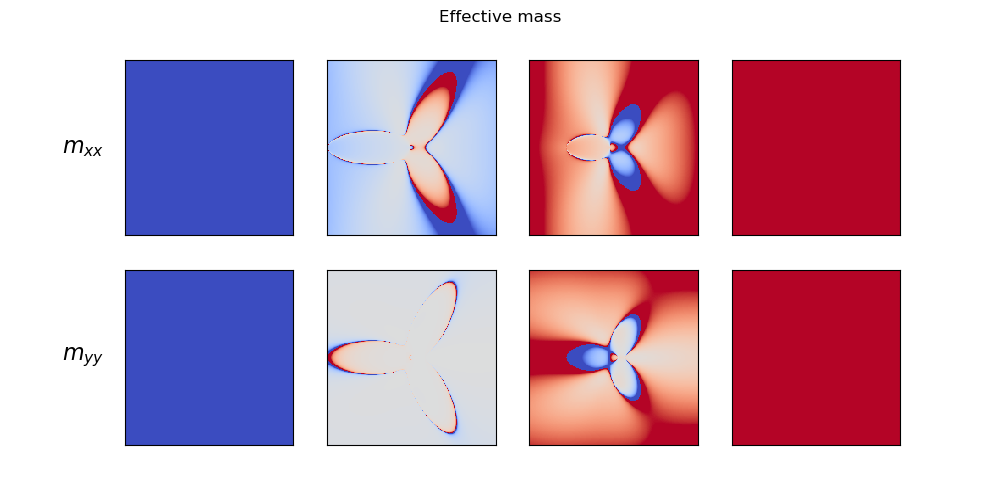

In [295]:
fig, ax = plt.subplots(2,4, figsize=(10,5))

for j in range(4):  # bands
    data00 = meff[j, :, :, 0, 0]
    data11 = meff[j, :, :, 1, 1]
    
    vmax00 = .1*data00.std()
    vmax11 = .1*data11.std()
    
    ax[0,j].pcolormesh(Kx, Ky, data00, cmap='coolwarm', vmin=-vmax00, vmax=vmax00)#, vmin=data00.mean()-2*data00.std(), vmax = data00.mean()+2*data00.std())
    ax[1,j].pcolormesh(Kx, Ky, data11, cmap='coolwarm', vmin=-vmax11, vmax=vmax11)#, vmin=data11.mean()-2*data11.std(), vmax = data11.mean()+2*data11.std())

ax[0,0].set_ylabel('$m_{xx}$', rotation=0, labelpad=30, fontsize=16, va='center')
ax[1,0].set_ylabel('$m_{yy}$', rotation=0, labelpad=30, fontsize=16, va='center')
    
fig.suptitle('Effective mass. Blue: negative (hole), Red: positive (electron)')

for a in ax.flatten():
    a.set_xticks([])
    a.set_yticks([])

Note: effective mass $m_{xx}$ and $m_{yy}$ is always negative (positive) for the high-energy hole (electron) band

In [283]:
(meff[0, :, :, 0, 0] < 0).all(), (meff[0, :, :, 1, 1] < 0).all(), (meff[3, :, :, 0, 0] >0).all(), (meff[3, :, :, 1, 1] >0).all(), 

(True, True, True, True)

This is not true for the low-energy bands. The curvature of the bands changes sign. What to do about this?

In [286]:
(meff[1, :, :, 0, 0] < 0).all(), (meff[1, :, :, 1, 1] < 0).all(), (meff[2, :, :, 0, 0] >0).all(), (meff[2, :, :, 1, 1] >0).all(), 

(False, False, False, False)

In [288]:
d = meff[1, :, :, 0, 0] 
d[d>0]

array([32.84760643, 16.6881529 , 12.99265686, ..., 13.55301271,
       18.64487925, 47.14966633])

# Carrier density (total and on each layer)

$\ntot = g_s g_v \sum_n \int \frac{\dd \kk}{(2\pi)^2}\feqn(\kk)$ is the carrier density. Note, this has to be an integral over the entire Brillouin zone. Away from the K and K' points, the Fermi-Dirac distribution should be constant. The highest and lowest bands do not contribute unless $E_F\approx > 300$ meV or the temperature is high enough?

## Fermi-Dirac distribution

Let's look at the Fermi-Dirac distribution over $k$ space:

<IPython.core.display.Javascript object>


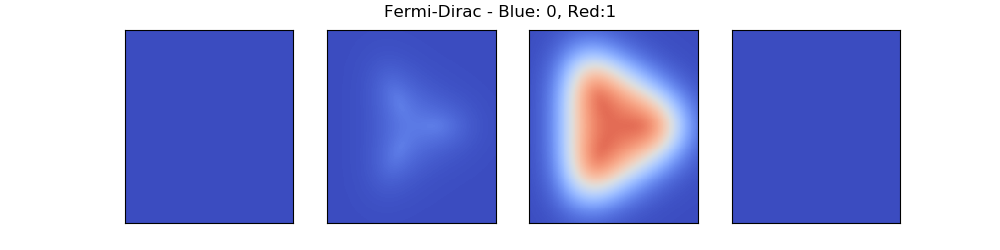

F-D dist in band 2 not smaller than 0.010000 at boundaries!


In [331]:
fig, ax = plt.subplots(1, 4, figsize=(10,2.5))

data = feq_func(E, .05, T=300)

for j in range(4):  # bands
    ax[j].pcolormesh(Kx, Ky, data[j], cmap='coolwarm', vmin= 0, vmax = 1)

# ax[0].set_ylabel('$f$', rotation=0, labelpad=30, fontsize=16, va='center')
    
fig.suptitle('Fermi-Dirac - Blue: 0, Red:1')

for a in ax.flatten():
    a.set_xticks([])
    a.set_yticks([])

## Side note: how much $k$-space should we cover?

We want to have enough $k$-space such that the Fermi-Dirac distribution is zero (below some threshold) at all boundaries of the region of $k$ space we look at in proximity to each valley, but not so much that the region extends into the vicinity of the neighboring valley.

The valleys are separated by $\Delta k= \frac{4\pi}{3\sqrt{3}a}\sim 9.83$ nm$^{-1}$ (double check!), where $a=0.246$ nm is the lattice constant for graphene. Let's make sure to only cover much less than half this distance in our integration over $k$-space. So let's restrict our $k$'s to $<1$ nm$^{-1}$. So far, we have used $k$ up to 0.35 nm$^{-1}$. Increasing the range of $k$s will decrease our resolution / increase computation time but will allow us to access a broader energy range. As the plots above show, $k$ up to 0.35 nm$^{-1}$ restricts the energy to $\lesssim 50$ meV, especially at high temperatures (the Fermi-Dirac distribution keeps changing at the boundary)

In [307]:
Kx.max()*1e-9, Ky.max()*1e-9

(0.3500000000000001, 0.3500000000000001)

In [351]:
2 * kx.max()*2 * ky.max()*2 / A_BZ # fraction of the area of the BZ we are sampling (counting both K and K')

0.0017346262788757044

At $T=300$ K and $E_F= 50$ meV, the Fermi-Dirac distribution reaches a minimum of ~0.001 in the band with the highest overall occupation (at the lower right corner of the above plots). We should check if $f>0.01$ at the boundaries and print a warning if not! I updated the `feq_func` definition to include this check.

In [314]:
data[1].min(), data[2].min(), data[2, -1, -1]

(6.825478069438784e-05, 0.0008207983907130597, 0.0008207983907130597)

# This notebook is getting long. Let's write a module for the above and calculate the macroscopic properties in a separate notebook (drafts below)

## Total carrier density

In [333]:
def ntot_func(kx, ky, E, EF, T=0):
    feq = feq_func(E, EF, T)
    # double integral over kx, ky working backwards along array axes
    integral = simps(simps(feq, kx), ky) # length 4 array
    print(integral)
    
    frac_BZ = 2 * 
    
    return 2 * 2 / (2 * np.pi) ** 2 * integral.sum()

In [339]:
ntot_func(kx, ky, E, -.05)

[0.00000000e+00 1.73079468e+17 0.00000000e+00 0.00000000e+00]


1.7536616530557824e+16

<IPython.core.display.Javascript object>


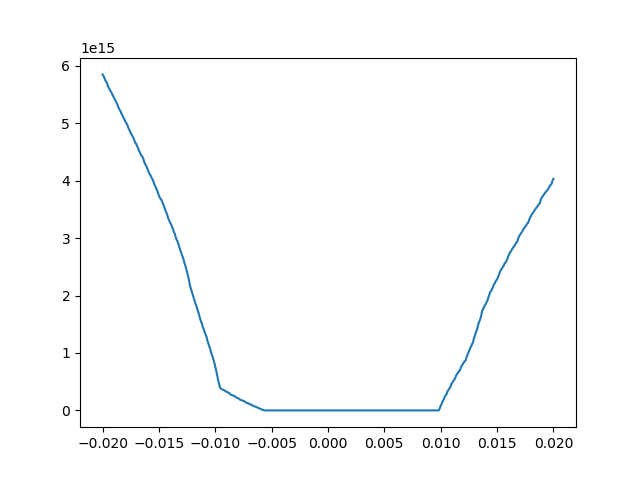

In [183]:
EF = np.linspace(-.02, .02,500)
ntot = np.zeros_like(EF)
for i, ef in enumerate(EF):
    ntot[i] = ntot_func(kx, ky, E, ef, T=0)
    
fig, ax = plt.subplots()
ax.plot(EF, ntot)

# Calculate magnetization

The valley magnetization is an integral over the Brillouin zone of both the magnetic moment and the Berry curvature:

$$
M_z = \frac{1}{2 n_{\text{tot}}}\sum_n \int \frac{d^2\mathbf{k}}{(2\pi)^2}\left[\nabla f_{\text{eq}}^n(\mathbf{k})\cdot \left(\frac{1}{\mathbf{m}^{*n}(\mathbf k)/m_e}\right)^{-1}\cdot \mathbf{j}\right]\left(\frac{\mu_z^n(\mathbf{k})}{\mu_B} + \frac{e\Omega_z^n(\mathbf{k})}{\hbar\mu_B}[\mu-E_n(\mathbf{k})]\right).
$$


$$\newcommand{\kk}{\mathbf{k}}\newcommand{\feqn}{f_{\text{eq}}^n}\newcommand{\ntot}{n_{\text{tot}}}\newcommand{\dd}{\text{d}}$$
Here, $\mathbf{j}$ is the current density, $\ntot = g_s g_v \sum_n \int \frac{\dd \kk}{(2\pi)^2}\feqn(\kk)$ is the carrier density, and ${\mathbf{m}^{*n}}$ is the effective mass tensor with components $\left(\frac{1}{m^{*n}}\right)_{ij} = \frac{1}{\hbar^2}\frac{\partial^2 E_n}{\partial k_i \partial k_j}$

We see from the plots above that Berry curvature and magnetization are sharply peaked near the $K$ (or $K'$) valley center, so integrating over the field of view we set up should take care of the entire Brillouin zone.

_Note: do we need a factor of 3 for the equivalent valleys at the other corners of the BZ? Probably not, because only 1/3 of the k-space around each valley is in the first BZ_

In [363]:
def Mfunc(kx, ky, E, Omega, Mu, Delta=0.02, delta=0.02, 
              xi=1, theta=0, J=[0, 0], tau=0, EF=0, T=0):
    # J given in x, y coordinates
    Ex, Ey = Efield
    f = feq(E, EF, T)
    
    f_dky, f_dkx = np.gradient(f, ky, kx, axis=(1,2)) # axis1 = y, axis2 = x
    
    term1 = f_dkx * Ex + f_dky * Ey
    term2 = Mu + e*Omega/hbar * (EF - E)
    
    integrand = (q * tau / hbar) * term1 * term2 / (2*pi) ** 2
    

In [29]:
f = feq(E, 0, 100)
f.shape

(4, 100, 100)

In [31]:
f_dky, f_dkx = np.gradient(f, ky, kx, axis=(1,2))
f_dkx.shape, f_dky.shape

((4, 100, 100), (4, 100, 100))

In [41]:
x = np.linspace(0,2,3)
y = np.linspace(0,4,3)

X,Y = np.meshgrid(x,y)

Z = X+Y

In [46]:
np.gradient(Z, y, x, axis=(1,0))

[array([[0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5]]), array([[2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.]])]